# Image Colorization with U-Net and GAN Tutorial

In [1]:
import os
import glob
import time
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torch import nn, optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1oRV2Y0DZYDNBfTMkcEB6V_GL82u-YzFX #dataset
!gdown --id 1ACRzAIg_v64iZ6fwOO7CQmt4D0vxLczV #utils
!gdown --id 1TeY1q_vvZia4ryIKLtq9aIkG9vGjSEb- #patch_discriminator
!gdown --id 1FsLpLN612SZATZQhnq2h90V5HcKmF5SI #generator

from utils import *
from dataset import *
from discriminator import *
from encoder import *

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1oRV2Y0DZYDNBfTMkcEB6V_GL82u-YzFX
To: /content/dataset.py
100% 818/818 [00:00<00:00, 1.47MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ACRzAIg_v64iZ6fwOO7CQmt4D0vxLczV
To: /content/utils.py
100% 712/712 [00:00<00:00, 1.36MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.g

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fastai==2.4

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 515, in _det

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
paths = glob.glob(coco_path + "/*.jpg") 
np.random.seed(123)
paths_subset = np.random.choice(paths, 10000, replace=False) 
rand_idxs = np.random.permutation(10000)
train_idxs = rand_idxs[:8000] 
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


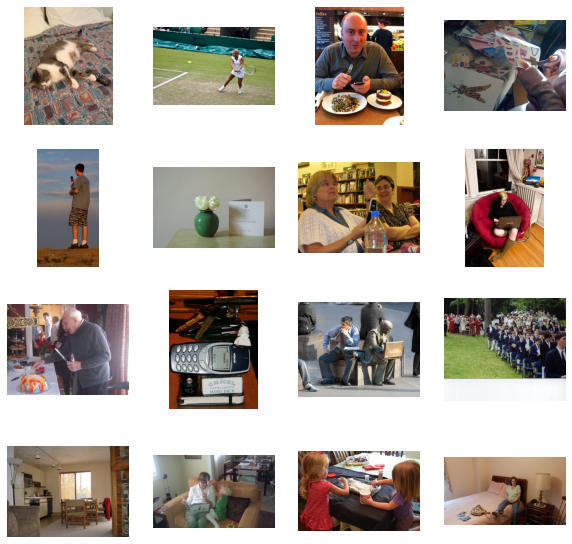

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Making Datasets and DataLoaders

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1, 1, 720, 1280]) torch.Size([1, 2, 720, 1280])
1000 2000


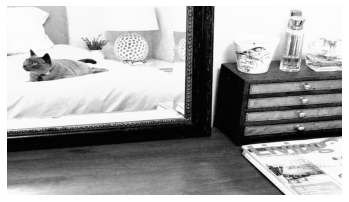

In [ ]:
transform = transforms.Compose([
                transforms.Resize((256, 256),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
dataset = DATASET(paths=train_paths, transform = transform)
train_loader = DataLoader(dataset, batch_size=8, num_workers=0, pin_memory=True)

dataset = DATASET(paths=val_paths, transform = transforms.Resize((720, 1280),  Image.BICUBIC))
val_loader = DataLoader(dataset, batch_size=1, num_workers=0, pin_memory=True)

for (dict_) in tqdm(val_loader):
    print(dict_[0].shape, dict_[1].shape)
    print(len(train_loader), len(val_loader))
    plt.axis(False)
    plt.imshow(dict_[0][0].squeeze(0),'gray')
    break

In [ ]:
print("Number of batches : ", len(train_loader), len(val_loader))
print("Number of datapoints : ", len(train_loader.dataset), len(val_loader.dataset))

Number of batches :  1000 2000
Number of datapoints :  8000 2000


<h2>1.3- Generator

In [ ]:
load_model('res18-unet.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded


1.4- Training

In [ ]:
net_G = Generator(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))

<All keys matched successfully>

In [ ]:
net_D = PatchDiscriminator(in_channels = 3) 
net_D.to(device)    
print('Loaded model onto GPU.') 

Loaded model onto GPU.


In [ ]:
import pandas as pd
metric_wgan= pd.DataFrame(columns = ['Generator Loss', 'Discriminator Loss' ])

In [ ]:
def gradient_penalty(color, fake, device="cpu"):
    batch,channels, height,width = color.shape
    alpha = torch.rand((batch, 1, 1, 1)).repeat(1, channels,height, width).to(device)
    interpolation = color * alpha + fake * (1 - alpha)

  
    scores = net_D(interpolation)

    # Take the gradient of the scores with respect to the images
    grad = torch.autograd.grad(
        inputs=interpolation,
        outputs=scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    grad = grad.view(grad.shape[0], -1)
    grad_norm = grad.norm(2, dim=1)
    grad_penalty = torch.mean((grad_norm - 1) ** 2)
    return grad_penalty


In [ ]:
opt_G = optim.Adam(net_G.parameters(), lr = 1e-4, betas=(0.0, 0.9))
opt_D = optim.Adam(net_D.parameters(), lr = 1e-4, betas=(0.0, 0.9))
max_train_loss = np.inf
criterion_L1 = nn.L1Loss()
epoch = 20

In [ ]:
net_G.train()
net_D.train()
net_G_loss = []
net_D_loss = []
discriminator_iterations=4
coeff_penalty = 10
for e in range(1, epoch+1):
  drive.mount('/content/drive')
  if(os.path.exists("/content/drive/MyDrive/cv thesis/wgan/model/metric_wgan.csv")):
    load_model("metric_wgan.csv")
    metric_wgan = pd.read_csv("metric_wgan.csv")
    drive.flush_and_unmount()
  g_loss_average = 0.0
  d_loss_average = 0.0
  for (L, ab) in tqdm(train_loader):
    L = L.to(device = device, dtype = torch.float32)
    ab = ab.to(device = device, dtype = torch.float32)
    out_ab = net_G(L) 
    fake = torch.cat([L, out_ab], dim = 1)
    color = torch.cat([L, ab], dim = 1)    

        
    for _ in range(discriminator_iterations):
      D_real = net_D(color)
      D_fake = net_D(fake.detach()) 
      penalty = gradient_penalty(color, fake, device=device)
      D_loss = (
                -(torch.mean(D_real) - torch.mean(D_fake)) + coeff_penalty * penalty
                  )
      net_D.zero_grad()
      D_loss.backward(retain_graph=True)
      opt_D.step()
      d_loss_average+=D_loss.item()
      
                
    
        # Train generator
        
    D_fake = net_D(fake) 
    G_loss = 50*criterion_L1(out_ab, ab) - torch.mean(D_fake)
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    g_loss_average+=G_loss.item()
      

  print(f"Epoch {e}:")
  print(f"Generator Loss: {g_loss_average/len(train_loader):.5f}")
  print(f"Discriminator Loss: {d_loss_average/len(train_loader):.5f}")
  net_D_loss.append(d_loss_average/len(train_loader))
  net_G_loss.append(g_loss_average/len(train_loader))
  metric_wgan = metric_wgan.append({'Generator Loss' : g_loss_average/len(train_loader), 'Discriminator Loss' : d_loss_average/len(train_loader)},ignore_index = True)
  metric_wgan.to_csv("metric_wgan.csv", index = False)
  save_model("metric_wgan.csv")
  if max_train_loss > g_loss_average:
    max_train_loss = g_loss_average
    print("Model Saved")
    torch.save(net_G.state_dict(), "./net_G-final.pth" )
    save_model(f"net_G-final.pth")
    torch.save(net_D.state_dict(), "./net_D-final.pth" )
    save_model(f"net_D-final.pth")
  print("------------------------------------------------------------------------------------------------------\n")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1:
Generator Loss: nan
Discriminator Loss: nan
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Saved
------------------------------------------------------------------------------------------------------

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded
Drive not mounted, so nothing to flush and unmount.


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### 1.7- Visualizing Results

In [ ]:
load_model("net_G-final.pth")
model = Generator(n_input=1, n_output=2, size=256)
model.load_state_dict(torch.load("./net_G-final.pth", map_location=device))

In [ ]:
if __name__ == '__main__':
    print('Starting validation.')    
    # Switch model to validation mode
    model.eval()    
    for (gray, ab) in tqdm(val_loader):
        
        L = gray.to(device = device, dtype = torch.float32)
        ab = ab.to(device = device, dtype = torch.float32)
        output = model(L) 
        
        fake = torch.cat([L, output], dim = 1).detach().cpu().numpy()
        for i in range(fake.shape[0]):
            color_image = fake[i]
            color_image = color_image.transpose((1, 2, 0))
            color_image[:, :, 0:1] = (color_image[:, :, 0:1] + 1.)* 50.
            color_image[:, :, 1:3] = color_image[:, :, 1:3] * 128.
            color_image = lab2rgb(color_image.astype(np.float64))
            plt.axis(False)
            plt.imshow(color_image)
            plt.show()

In [9]:
load_model("metric_wgan.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model Loaded


In [20]:
import pandas as pd
df= pd.read_csv("metric_wgan.csv")[:8]
df

,Generator Loss,Discriminator Loss
0,3.034923,114.983315
1,2.689797,4.577982
2,2.565720,3.311560
3,2.454938,2.450531
4,2.358346,1.515406
5,2.262699,0.236566
6,2.220962,0.217596
7,2.161206,0.195314


In [19]:
def plot_2(x, y1, y2, x_label, y_label, y1_label, y2_label):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, x + 1, 1), y1, marker='o', color = 'b', label = y1_label)
    plt.plot(np.arange(1, x + 1, 1), y2, marker='o', color = 'r', label = y2_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

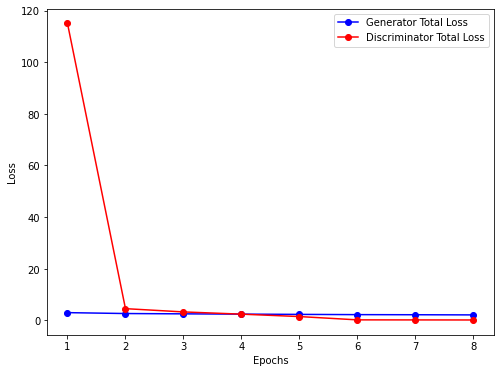

In [21]:
plot_2(len(df), df['Generator Loss'], df['Discriminator Loss'], "Epochs", "Loss", "Generator Total Loss", "Discriminator Total Loss")